In [1]:
import pandas as pd
import json
import en_core_web_sm
import spacy
import gensim.parsing.preprocessing
import pprint

In [2]:
input_path = '../../data/data_2021-02-01 22:27:13.862993.json'
output_path = '../../data/'

In [3]:
with open(input_path, encoding="utf-8") as f:
    data = json.load(f)
# Keywords from every paper  
keywords_df = pd.json_normalize(data['papers'])['keywords']

print("No of papers: {}".format(keywords_df.shape[0]))

No of papers: 2230


In [4]:
nlp = spacy.load("en_core_web_sm")
STOPWORDS = nlp.Defaults.stop_words

In [5]:
def process(flat_words, lemmatize=True, min_word_len=2):
  flat_words = [gensim.parsing.preprocessing.strip_non_alphanum(word) for word in flat_words]
  doc = spacy.tokens.Doc(nlp.vocab, words=flat_words)

  processed = []

  if lemmatize:
    processed = [token.lemma_ for token in doc]
    processed = [token.lower() for token in processed]
  else:
    processed = [token.lower_ for token in doc]

  processed = [token for token in processed if token not in STOPWORDS]
  processed = [token for token in processed if len(token) >= min_word_len]

  return processed


In [6]:
def process_corpus(keywords_df, lemmatize=True, min_word_len=2):
  processed_corpus = []
  flat_words = []

  # n: no of research papers
  # [[kw11, kw12, ...] ...[kwn1, kwn2, kwn3, ...]]
  keywords = keywords_df.tolist()
  # j: no of document in which the keyword is present
  # kwji -> [wji1, wij2, ...] ~ list of all words associated with keyword i of paper j
  # [kwj1, kwj2, ...] -> [kwj11, kwj12, wkwj13, kwj21, kwj22, ...] ~ list of all words associated with the keywords of paper j
  for l in keywords:
    tmp = []
    for keyword in l:
      words = keyword.split(" ")
      for word in words:
        tmp.append(word)
    flat_words.append(tmp)

  for l in flat_words:
    processed_corpus.append(process(l, True, 2))

  return processed_corpus


In [7]:
from gensim import corpora

processed_corpus = process_corpus(keywords_df)
dictionary = corpora.Dictionary(processed_corpus)

bow_corpus = [dictionary.doc2bow(words) for words in processed_corpus]


In [8]:
from gensim import models

# Train the model
tfidf = models.TfidfModel(bow_corpus)

In [9]:
from gensim import similarities

index = similarities.SparseMatrixSimilarity(tfidf[bow_corpus], num_features=len(dictionary.token2id))

In [10]:
from collections import defaultdict

def compute_similarities(processed_corpus, threshold=0.9):
  similarities = defaultdict(list)

  for query_doc_index in range(len(processed_corpus)):
    query_doc =  processed_corpus[query_doc_index]
    query_bow = dictionary.doc2bow(query_doc)
    sims = index[tfidf[query_bow]]
    for document_number, score in sorted(enumerate(sims), key=lambda x: x[1], reverse=True):
      if score >= threshold and document_number != query_doc_index:
        similarities[query_doc_index].append((document_number, score))

  return similarities


In [11]:
# Compute similarites between every two papers
sims = compute_similarities(processed_corpus, 0.0)

In [12]:
from collections import Counter
from math import floor
from tqdm import tqdm

avg_ws_thr = [0] * 11

last_mean = [0] *  11

for item in tqdm(sims.items()):
  curr_paper_ws = processed_corpus[item[0]]
  for paper in item[1]:
    if paper[0] > item[0]: 
      thr = (int) (floor(paper[1] * 10))
      paper_ws = processed_corpus[paper[0]]
      inter = list((Counter(curr_paper_ws) & Counter(paper_ws)).elements())
      last_mean[thr] += 1
      # Calculate rolling mean
      avg_ws_thr[thr] = avg_ws_thr[thr] + (len(inter) - avg_ws_thr[thr]) / last_mean[thr]

for thr in range(10):
  print("a 0.{}% similarity between papers coresponds to {} common words".format(thr, avg_ws_thr[thr]))
print("a 1.0% similarity between papers coresponds to {} common words".format(thr, avg_ws_thr[10]))

100%|██████████| 2230/2230 [00:37<00:00, 60.02it/s]a 0.0% similarity between papers coresponds to 0.2926255174554257 common words
a 0.1% similarity between papers coresponds to 2.0650985322495887 common words
a 0.2% similarity between papers coresponds to 2.899430443941645 common words
a 0.3% similarity between papers coresponds to 3.64901764901765 common words
a 0.4% similarity between papers coresponds to 4.3540856031128445 common words
a 0.5% similarity between papers coresponds to 5.097959183673468 common words
a 0.6% similarity between papers coresponds to 6.199999999999999 common words
a 0.7% similarity between papers coresponds to 7.933333333333334 common words
a 0.8% similarity between papers coresponds to 7.4 common words
a 0.9% similarity between papers coresponds to 10.2 common words
a 1.0% similarity between papers coresponds to 9 common words



In [13]:
from sklearn.metrics.pairwise import cosine_distances
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

dist = cosine_distances(index)

Estimated number of clusters: 38


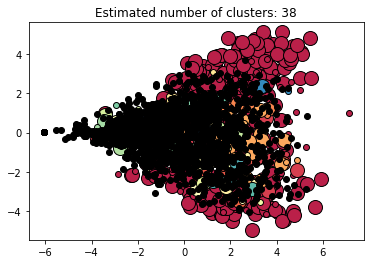

In [14]:
db = DBSCAN(
        eps=0.3,
        min_samples=3,
        metric='precomputed',
        algorithm='brute').fit(dist)

labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('Estimated number of clusters: %d' % n_clusters_)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

#  Perform dimensional reduction of the distance matrix with PCA
X = PCA(n_components=2).fit_transform(dist) 

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [16]:

#clustered_papers = pd.DataFrame({'words': processed_corpus, 'cluster': db.labels_}, columns=['words', 'cluster'])
print('../../data/' + '{}_labeled.json'.format(input_path.split('/')[-1][:-5]))

../../data/data_2021-02-01 22:27:13.862993_labeled.json


In [36]:
# Write labeled papers to json
clustered_papers = []
keys = ['words', 'cluster']

for i in range(len(processed_corpus)):
    vals = [processed_corpus[i], int(db.labels_[i])]
    clustered_papers.append(dict(zip(keys, vals)))


with open('../../data/' + '{}_labeled.json'.format(input_path.split('/')[-1][:-5]), 'w') as f:
        json.dump({'clustered_papers':clustered_papers}, f, ensure_ascii=False, indent=4)




In [52]:
classmethod

 'learn',
   'local',
   'online'],
  ['bayesian',
   'network',
   'structure',
   'learn',
   'property',
   'decomposable',
   'score',
   'structural',
   'constraint',
   'branch and bound',
   'technique'],
  ['latent',
   'variable',
   'model',
   'variational',
   'bayesian',
   'learn',
   'graphical',
   'model',
   'build',
   'block',
   'bayesian',
   'model',
   'local',
   'computation'],
  ['ordinal',
   'regression',
   'ordinal',
   'classification',
   'matlab',
   'octave',
   'threshold',
   'model'],
  ['causal',
   'inference',
   'structural',
   'equation',
   'model',
   'additive',
   'noise',
   'identifiability',
   'causal',
   'minimality',
   'bayesian',
   'network'],
  ['pattern',
   'discovery',
   'motif',
   'discovery',
   'locality',
   'sensitive',
   'hash',
   'classification'],
  ['significance',
   'test',
   'neural',
   'network',
   'model',
   'interpretability',
   'nonparametric',
   'regression',
   'nonlinear',
   'regression',
   'f